# Linear Regression with Gradient Descent: A Python Tutorial

Ozzie Liu - ozzieliu.com - ozzie@ozzieliu.com

*I learn best by doing and teaching*. And while Python has some excellent packages available for linear regression (like Statsmodels or Scikit-learn), I wanted to understand the intuition behind ordinay least squares (OLS) linear regression. How is the best fit found? How do you actually implement gradient descent?

This guide is primarily modeled after Andrew Ng's excellent [Machine Learning course](http://www.ml-class.org/) available online for free. The programming exercises there are straightfoward and intuitive, but it's mainly in Matlab/Octave. I wanted to implement the same thing in Python with Numpy arrays.

Contents:
- Loading and looking at data
- Cost function
- Gradient Descent

Packages:  
`Pandas` for data frames and easy to read csv files  
`Numpy` for array and matrix mathematics functions  
`Matplotlib` for plotting

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Data

In the first exercise, we're performing a linear regression with one variable to predict profits for a food truck. The data contains 2 columns, population of a city (in 10,000s) and the profits of the food truck (in 10,000s). 

In [80]:
data = pd.read_csv('./scores.xlsx')
# df=pd.read_csv('./scores.xlsx')


In [81]:
print (data.head())

     name  math  cs
0   david    92  98
1   laura    56  68
2  sanjay    88  81
3     wei    70  80
4    jeff    80  83


## Plotting the Data

In [82]:
## Split population and profit into X and y
X_df = pd.DataFrame(data.math)
y_df = pd.DataFrame(data.cs)

## Length, or number of observations, in our data
m = len(y_df)

Text(0, 0.5, 'Profit in $10,000s')

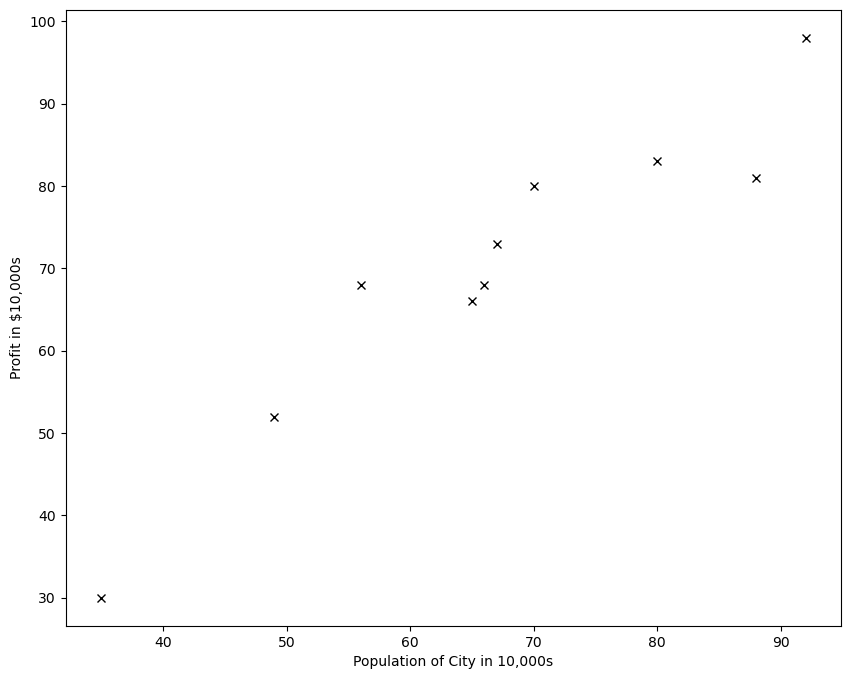

In [83]:
plt.figure(figsize=(10,8))
plt.plot(X_df, y_df, 'kx')
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')

The idea of linear regression is to find a relationship between our target or dependent variable (y) and a set of explanatory variables ($x_1, x_2...$). This relatonship can then be used to predict other values.

In our case with one variable, this relationship is a line defined by parameters $\beta$ and the following form: $y = \beta_0 + \beta_1x$, where $\beta_0$ is our intercept.

This can be extended to multivariable regression by extending the equation in vector form: $y=X\beta$

So how do I make the best line? In this figure, there are many possible lines. Which one is the best?

Text(0, 0.5, 'Profit in $10,000s')

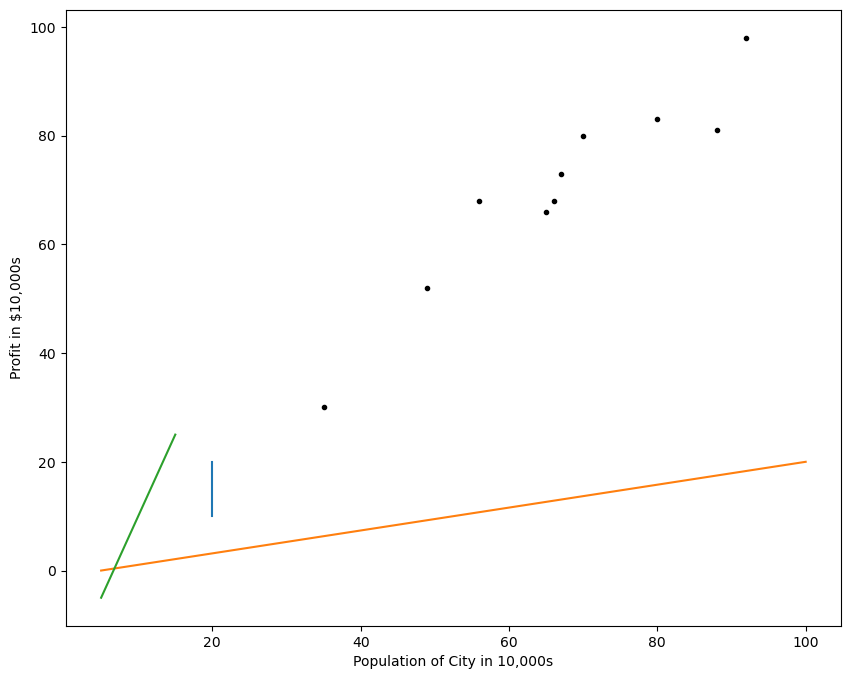

In [84]:
plt.figure(figsize=(10,8))
plt.plot(X_df, y_df, 'k.')
plt.plot([20, 20], [10,20], '-')
plt.plot([5, 100], [0,20], '-')
plt.plot([5, 15], [-5,25], '-')
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')

## Cost Function
It turns out that to make the best line to model the data, we want to pick parameters $\beta$ that allows our predicted value to be as close to the actual value as possible. In other words, we want the distance or residual between our hypothesis $h(x)$ and y to be minimized.

So we formally define a cost function using ordinary least squares that is simply the sum of the squared distances. To find the liner regression line, we minimize:
$$J(\beta) = \frac{1}{2m}\sum_{i=1}^m(h_\beta(x^{(i)})-y^{(i)})^2$$

Again the hypothesis that we're trying to find is given by the linear model:
$$h_\beta(x) = \beta^{T}x = \beta_0 + \beta_1x_1$$

The parameters of the model are the beta values. We adjust $\beta_j$ to minimze the cost function $J(\beta)$. 

And we can use batch gradient descent where each iteration performs the update
$$\beta_j := \beta_j - \alpha\frac{1}{m}\sum_{i=1}^m (h_\beta(x^{(i)})-y^{(i)})x_{j}^{(i)}$$

Whoa, what's gradient descent? And why are we updating that?

Gradient descent simply is an algorithm that makes small steps along a function to find a local minimum. We can look at a simply quadratic equation such as this one:

In [85]:
x_quad = [n/10 for n in range(0, 100)]
y_quad = [(n-4)**2+5 for n in x_quad]


Text(0.5, 1.0, 'Quadratic Equation')

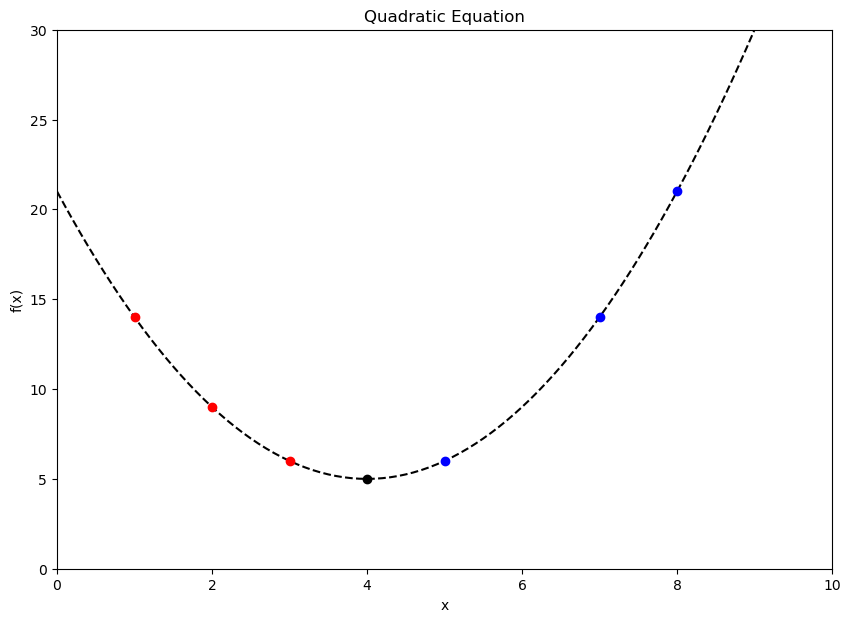

In [86]:
plt.figure(figsize = (10,7))
plt.plot(x_quad, y_quad, 'k--')
plt.axis([0,10,0,30])
plt.plot([1, 2, 3], [14, 9, 6], 'ro')
plt.plot([5, 7, 8],[6, 14, 21], 'bo')
plt.plot(4, 5, 'ko')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Quadratic Equation')

We're trying to find the local minimum on this function. If we start at the first red dot at x = 2, we find the gradient and we move against it. In this case, the gradient is the slope. And since the slope is negative, our next attempt is further to the right. Thus bringing us closer to the minimum. 

Indeed, we keep updating our parameter beta to get us closer and closer to the minumum.
$$\beta_j := \beta_j - \alpha\frac{\partial}{\partial \beta_j} J(\beta)$$
Where $\alpha$ is our learning rate and $J(\beta)$ is our cost function. By adjusting alpha, we can change how quickly we converge on the minimum (at the risk of overshooting it entirely and does not converge on our local minimum)

Derive into the final formula?

OK, let's try to implement this in Python. First I declare some parameters. Alpha is my learning rate, and iterations defines how many times I want to perform the update.

Then I transform the data frame holding my data into an array for simpler matrix math. And then write a helper function to calculate the cost function as defined above. Using np.dot for inner matrix multiplication

In [87]:
iterations = 150
alpha = 0.01

In [88]:
## Add a columns of 1s as intercept to X
X_df['intercept'] = 1

## Transform to Numpy arrays for easier matrix math and start theta at 0
X = np.array(X_df)
y = np.array(y_df).flatten()
theta = np.array([0, 0])


In [89]:
def cost_function(X, y, theta):
    """
    cost_function(X, y, theta) computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(y) 
    
    ## Calculate the cost with the given parameters
    J = np.sum((X.dot(theta)-y)**2)/2/m
    
    return J

In [90]:
cost_function(X, y, theta)

2599.55

Now, I split the gradient descent algorithm into 4 parts so that I can see what's going on. Plus, I like to check my matrix dimensions to make sure that I'm doing the math in the right order.
1. calculate hypothesis[97x1] = x[97x2] * theta[2x1]
2. calculte loss [97x1] with element-wise subtraction
3. calculate gradient [2x1] = X' [2x97] * loss [97*1]
4. update parameter theta [2x1] after element-wise subtraction multiplied by a scalar
5. find the cost by using cost_function()

In [91]:
import warnings

#suppress warnings
warnings.filterwarnings('ignore')
def gradient_descent(X, y, theta, alpha, iterations):
    """
    gradient_descent Performs gradient descent to learn theta
    theta = GRADIENTDESENT(X, y, theta, alpha, num_iters) updates theta by 
    taking num_iters gradient steps with learning rate alpha
    """
    cost_history = [0] * iterations
    
    for iteration in range(iterations):
        hypothesis = X.dot(theta)
        loss = hypothesis-y
        gradient = X.T.dot(loss)/m
        theta = theta - alpha*gradient
        cost = cost_function(X, y, theta)
        cost_history[iteration] = cost

    return theta, cost_history
     

In [92]:
(t, c) = gradient_descent(X,y,theta,0.01, iterations)

In [93]:
## Print theta parameters
print (t)

[-8.42528970e+249 -1.18888081e+248]


In [94]:
## Prediction
print( np.array([3.5, 1]).dot(t))
print( np.array([7, 1]).dot(t))

-2.96074020426179e+250
-5.909591600418148e+250


In [95]:
## Plotting the best fit line
best_fit_x = np.linspace(0, 25, 20)
best_fit_y = [t[1] + t[0]*xx for xx in best_fit_x]

Text(0.5, 1.0, 'Profit vs. Population with Linear Regression Line')

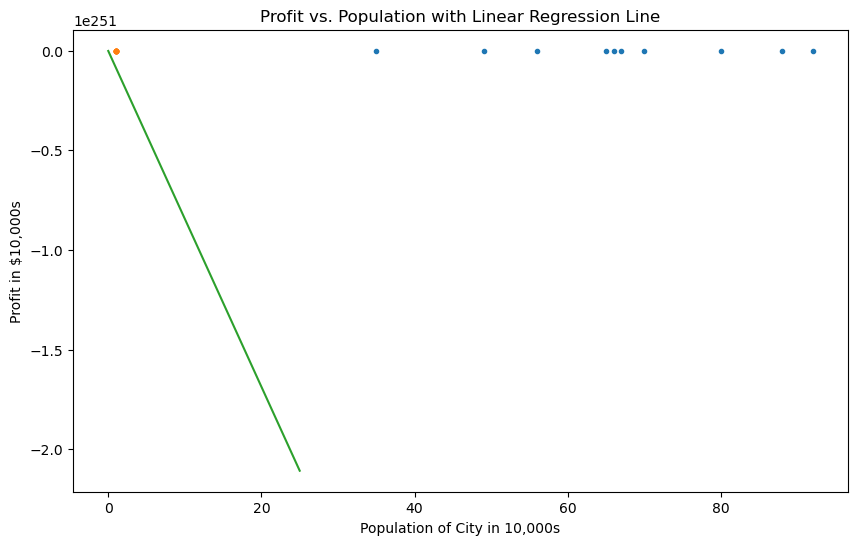

In [97]:
plt.figure(figsize=(10,6))
plt.plot(X_df, y_df, '.')
plt.plot(best_fit_x, best_fit_y, '-')
# plt.axis([0,25,-5,25])
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.title('Profit vs. Population with Linear Regression Line')